In [1]:
from pytesseract import Output
import numpy as np
import pytesseract
import imutils
import cv2
import os
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [2]:
from PIL import Image
import PIL

In [3]:
from tensorflow.keras.models import load_model
from helper_functions import improve_quality

In [4]:
import time

In [5]:
current_location = os.getcwd()
unet_path=os.path.join(current_location,"assets/models/unet model")
unet = load_model(unet_path)
image_path = os.path.join(current_location,"testing.jpg")
min_conf = 0.1
distance_thresh = 20
min_size = 1
np.random.seed(42)

In [6]:
image = cv2.imread(image_path)
start_time = time.time()
improved_image = improve_quality(image)
end_time = time.time()
print("process took : ", end_time-start_time)

model loaded
2924
0 -1
0 -1
0 0


IndexError: index 1 is out of bounds for axis 0 with size 1

In [23]:
segmented_image = np.zeros(improved_image.shape)
(h,w) = improved_image.shape[:2]
newh = h -h%128
neww = w -w%128

In [28]:
for i in range(0,newh,128):
    for j in range(0,neww,128):
        crop = improved_image[i:i+128,j:j+128].astype("float32")
        crop*=1./255.
        segmented = unet.predict(np.expand_dims(crop, axis=0))
        segmented = segmented.reshape((128, 128, 3))
        segmented *=255.
        segmented_image[i:i+128,j:j+128] = segmented

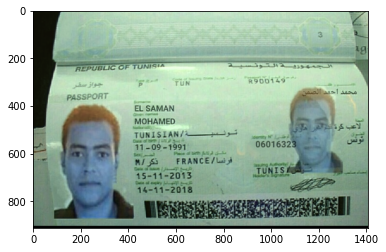

In [63]:
plt.imshow(improved_image)
plt.show()

# ABORT !!!

In [30]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 8))
gray = cv2.GaussianBlur(gray, (3, 3), 0)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, kernel)
thresh = cv2.threshold(grad, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = cv2.dilate(thresh, None, iterations=3)

In [33]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
boxes=[]
text_objects=[]
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    if h*w> 200:
        boxes.append((x, y, w, h))
        info = image[y:y + h, x:x + w]
        text_objects.append(info)

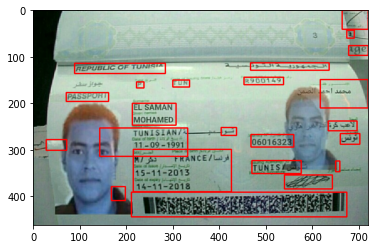

In [34]:
im = image
for box in boxes:
    (x, y, w, h) = box
    cv2.rectangle(im,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(im)
plt.show()

Conclusion : improved image is better

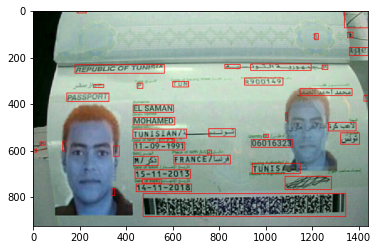

In [52]:
(h,w)=image.shape[:2]
bigger_image = np.array(Image.fromarray(image).resize((w*2,h*2),resample=PIL.Image.BICUBIC))
gray = cv2.cvtColor(bigger_image, cv2.COLOR_BGR2GRAY)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 8))
gray = cv2.GaussianBlur(gray, (3, 3), 0)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, kernel)
thresh = cv2.threshold(grad, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = cv2.dilate(thresh, None, iterations=3)

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
boxes=[]
text_objects=[]
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    if h*w> 200:
        boxes.append((x, y, w, h))
        info = bigger_image[y:y + h, x:x + w]
        text_objects.append(info)
        
im = bigger_image
for box in boxes:
    (x, y, w, h) = box
    cv2.rectangle(im,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(im)
plt.show()

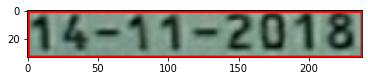

In [53]:
plt.imshow(text_objects[2])
plt.show()

old :  (33, 238)  new :  (128, 256)


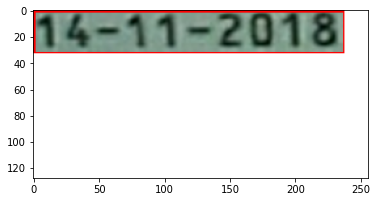

In [60]:
expiration_date = text_objects[2]
(h,w) = expiration_date.shape[:2]
newh = h -h%128 +128
neww = w -w%128 +128
print("old : ", (h,w) ," new : ",(newh,neww))
expiration_date = cv2.copyMakeBorder(expiration_date, 0,128- h%128, 0,128- w%128, cv2.BORDER_CONSTANT,value = [255,255,255])
plt.imshow(expiration_date)
plt.show()
segmented_date = np.zeros(expiration_date.shape)
for i in range(0,newh,128):
    for j in range(0,neww,128):
        crop = expiration_date[i:i+128,j:j+128].astype("float32")
        crop*=1./255.
        segmented = unet.predict(np.expand_dims(crop, axis=0))
        segmented = segmented.reshape((128, 128, 3))
        segmented *=255.
        segmented_date[i:i+128,j:j+128] = segmented

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


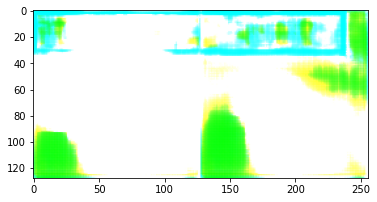

In [61]:
plt.imshow(segmented_date)
plt.show()